In [133]:
!wmic path win32_VideoController get Caption,DeviceID,VideoProcessor

Caption                  DeviceID          VideoProcessor           

NVIDIA GeForce RTX 3070  VideoController1  NVIDIA GeForce RTX 3070  





In [134]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb

In [151]:
def LightGBM_All(filename):

    # 通过第一个_和第二个_截取站点名词
    first_underscore_index = filename.find("_")
    second_underscore_index = filename.find("_", first_underscore_index + 1)
    site_name = filename[first_underscore_index + 1:second_underscore_index]
    print('For '+site_name)

    CN_Cha_Data=pd.read_csv('../Data/NOAA/All Station/{}'.format(filename))

    # 将日期和时间合并为一个列，并将其设置为DataFrame的索引
    CN_Cha_Data['DateTime'] = pd.to_datetime(CN_Cha_Data['Date'] + ' ' + CN_Cha_Data['Time (GMT)'])
    CN_Cha_Data.set_index('DateTime', inplace=True)
    '''
    CN_Cha_Data =CN_Cha_Data[['Wind Speed (m/s)', 'Wind Dir (deg)','Wind Gust (m/s)', 'Air Temp (°C)', 'Baro (mb)', 'Water Level(m)']]
    col_CN_ha_Data = [['Wind Speed (m/s)_CHA', 'Wind Dir (deg)_CHA','Wind Gust (m/s)_CHA', 'Air Temp (°C)_CHA', 'Baro (mb)_CHA', 'Water Level(m)_CHA']]
    '''
    CN_Cha_Data =CN_Cha_Data[['Wind Speed (m/s)', 'Wind Dir (deg)', 'Wind Gust (m/s)', 'Air Temp (°C)', 'Baro (mb)', 'Water Level(m)']]
    col_CN_ha_Data = [['Wind Speed (m/s)_CHA', 'Wind Dir (deg)_CHA','Wind Gust (m/s)_CHA', 'Air Temp (°C)_CHA', 'Baro (mb)_CHA', 'Water Level(m)_CHA']]
    CN_Cha_Data.columns=col_CN_ha_Data
    dataset=CN_Cha_Data
    var=dataset.values

    # 将数据分割为训练集和测试集
    train_months = [1, 2, 4, 5, 7, 8, 10]
    val_months = [11]
    test_months = [9]

    train_data = var[CN_Cha_Data.index.month.isin(train_months)]
    val_data = var[CN_Cha_Data.index.month.isin(val_months)]
    test_data = var[CN_Cha_Data.index.month.isin(test_months)]

    # def splitData(var,per_val,per_test):
    #     num_val=int(len(var)*per_val)
    #     num_test=int(len(var)*per_test)
    #     train_size=int(len(var)-num_val-num_test)
    #     train_data=var[0:train_size]
    #     val_data=var[train_size:train_size+num_val]
    #     test_data=var[train_size+num_val:train_size+num_val+num_test]
    #     return train_data,val_data,test_data
    # train_data,val_data,test_data=splitData(var,0.1,0.1)
    print('The length of train data, validation data and test data are:',len(train_data),',',len(val_data),',',len(test_data))

    # train_window = 240
    train_window = 1
    def create_train_sequence(input_data, tw):
        inout_seq = []
        L = len(input_data)
        for i in range(L-tw):
            train_seq = input_data[i:i+tw]
            train_label = input_data[i+tw:i+tw+1]
            inout_seq.append((train_seq ,train_label))
        return inout_seq
    train_inout_seq = create_train_sequence(train_data, train_window)
    print('The total number of train windows is',len(train_inout_seq))

    def create_val_sequence(train_data, val_data, tw):
        temp = np.vstack((train_data, val_data))  #先将训练集和测试集合并
        inout_seq = []
        L = len(val_data)
        for i in range(L):
            val_seq = temp[-(train_window + L) + i:-L + i]
            val_label = test_data[i:i + 1]
            inout_seq.append((val_seq, val_label))

        return inout_seq

    val_inout_seq = create_val_sequence(train_data, val_data, train_window)
    print('The total number of validation windows is', len(val_inout_seq))

    def create_test_sequence(train_data, val_data, test_data, tw):
        temp = np.vstack((train_data, val_data))  #先将训练集和测试集合并

        temp = np.vstack((temp, test_data))
        inout_seq = []
        L = len(test_data)
        for i in range(L):
            test_seq = temp[-(train_window + L) + i:-L + i]
            test_label = test_data[i:i + 1]
            inout_seq.append((test_seq, test_label))
            # print('test_reshape:',test_seq.reshape(-1))
            # inout_seq.append((test_seq.reshape(-1) ,test_label))

        return inout_seq

    test_inout_seq = create_test_sequence(train_data, val_data, test_data, train_window)
    print('The total number of validation windows is', len(val_inout_seq))

    X_train=np.array([x[0] for x in train_inout_seq])
    y_train=np.array([x[1] for x in train_inout_seq]).squeeze(1)

    X_val=np.array([x[0] for x in val_inout_seq])
    y_val=np.array([x[1] for x in val_inout_seq]).squeeze(1)

    X_test=np.array([x[0] for x in test_inout_seq])
    y_test=np.array([x[1] for x in test_inout_seq]).squeeze(1)


    X_train = X_train.reshape(len(X_train),-1)
    y_train = y_train.reshape(len(y_train),-1)

    X_val = X_val.reshape(len(X_val),-1)
    y_val = y_val.reshape(len(X_val),-1)

    X_test = X_test.reshape(len(X_test),-1)
    y_test = y_test.reshape(len(y_test),-1)

    params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 29,
    'learning_rate': 0.09,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 6,
    'verbose': 0
    }
    # params = {
    # 'boosting_type': 'gbdt',
    # 'objective': 'regression',
    # 'metric': {'l2', 'l1'},
    # 'num_leaves': 29,
    # 'learning_rate': 0.09,
    # 'feature_fraction': 0.1,
    # 'bagging_fraction': 0.3,
    # 'bagging_freq': 2,
    # 'verbose': 1
    # }

    index_dic={
    'Water Level(m)':5,
    # 'ss':2
    }


    import copy
    from sklearn.preprocessing import  MinMaxScaler as MinMax
    from sklearn.metrics import r2_score
    def predict_lgb_mul(attr):
      lgb_train = lgb.Dataset(X_train,y_train[:,index_dic[attr]])
      lgb_val = lgb.Dataset(X_val, y_val[:,index_dic[attr]], reference=lgb_train)

      gbm = lgb.train(params,
                      lgb_train,
                      num_boost_round=100,
                      valid_sets=lgb_val,
                      # early_stopping_rounds=5
                      )

      y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

      x = np.arange(len(train_data)+len(val_data), len(dataset), 1)
      plt.figure(figsize=(8, 6))
      plt.grid(True)

      plt.plot(y_test[:,index_dic[attr]],color="red",label='real value')
      plt.plot(y_pred,label='prediction')

      plt.title('half-hours vs '+attr+' for Train Set')
      plt.ylabel(attr)
      plt.xlabel('half-hour')

      plt.legend(loc='upper right',fontsize=15)
      # plt.savefig('lightGBM_SW_IN_F_Train.png')
      plt.show()
      scaler = MinMax(feature_range=(0,1))
      y_trian_true_scaled = scaler.fit_transform(np.array(y_test[:,index_dic[attr]]).reshape(-1,1))
      y_trian_pred_scaled = scaler.fit_transform(np.array(y_pred).reshape(-1,1))

      # print("============归一化前的结果==============")
      print('mse:', mean_squared_error(y_test[:,index_dic[attr]], y_pred))
      # print(y_test[-300:,5])
      print('mae:', mean_absolute_error(y_test[:,index_dic[attr]], y_pred))
      print('rmse:', np.sqrt(mean_squared_error(y_test[:,index_dic[attr]], y_pred)))
      print('R²: ',r2_score(y_test[:,index_dic[attr]], y_pred))
      data = {
         'Metric': ['R2', 'RMSE', 'MAE'],
         'Value': [r2_score(y_test[:,index_dic[attr]], y_pred),np.sqrt(mean_squared_error(y_test[:,index_dic[attr]], y_pred)),mean_absolute_error(y_test[:,index_dic[attr]], y_pred) ]
      }

      results_seaon = pd.DataFrame(data)
      # 保存DataFrame为CSV文件
      results_seaon.to_csv('KAHUKUI Station.cs_metrics_9.csv', index=False)
      y_true_re = y_test
      y_pred_re = y_pred
      # y_pred_data=pd.DataFrame(y_pred_re)
      # y_true_data=pd.DataFrame(y_true_re)
      # # # print('y_true:',y_true)
      # y_pred_data.to_csv('../ResultAnaAndProcess/NOAA_WL/WL_WS_AT/LightGBM/{}'.format(site_name)+'_LightGBM'+'_YPre_'+''+attr+'.csv',index=False)
      # y_true_data.to_csv('../ResultAnaAndProcess/NOAA_WL/WL_WS_AT/LightGBM/{}'.format(site_name)+'_LightGBM'+'_YTrue_'+attr+'.csv',index=False)

    predict_lgb_mul('Water Level(m)')

For eleventh
The length of train data, validation data and test data are: 5125 , 719 , 719
The total number of train windows is 5124
The total number of validation windows is 719
The total number of validation windows is 719
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's l2: 0.0463867	valid_0's l1: 0.177524
[2]	valid_0's l2: 0.0464103	valid_0's l1: 0.178055
[3]	valid_0's l2: 0.0468584	valid_0's l1: 0.179452
[4]	valid_0's l2: 0.0477073	valid_0's l1: 0.181398
[5]	valid_0's l2: 0.0488175	valid_0's l1: 0.183644
[6]	valid_0's l2: 0.0501166	valid_0's l1: 0.186245
[7]	valid_0's l2: 0.05151	valid_0's l1: 0.188804
[8]	valid_0's l2: 0.0529939	valid_0's l1: 0.191478
[9]	valid_0's l2: 0.054537	valid_0's l1: 0.194241
[10]	valid_0's l2: 0.0543968	valid_0's l1: 0.194054
[11]	valid_0's l2: 0.0542523	valid_0's l1: 0.193786
[12]	valid_0's l2: 0.0557197	valid_0's l1: 0.19632

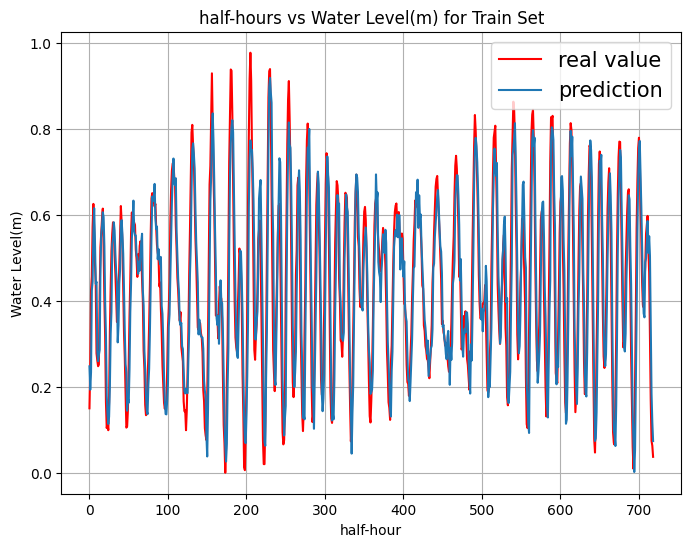

mse: 0.009164155284352049
mae: 0.07756058213945413
rmse: 0.09572959461082058
R²:  0.7844562585582397


In [152]:
LightGBM_All('KAHUKUI Station Modify_eleventh_sub.csv')

In [131]:
# LightGBM_All('FLX_AU-ASM_FLUXNET2015_FULLSET_HH_2010-2014_2-4.csv')

For Burlington Station.cs
The length of train data, validation data and test data are: 5131 , 720 , 720
The total number of train windows is 5130
The total number of validation windows is 720
The total number of validation windows is 720
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's l2: 0.57711	valid_0's l1: 0.663331
[2]	valid_0's l2: 0.547112	valid_0's l1: 0.643949
[3]	valid_0's l2: 0.525461	valid_0's l1: 0.628704
[4]	valid_0's l2: 0.510811	valid_0's l1: 0.617275
[5]	valid_0's l2: 0.50069	valid_0's l1: 0.60807
[6]	valid_0's l2: 0.494055	valid_0's l1: 0.600491
[7]	valid_0's l2: 0.491031	valid_0's l1: 0.595687
[8]	valid_0's l2: 0.490602	valid_0's l1: 0.592619
[9]	valid_0's l2: 0.491762	valid_0's l1: 0.590896
[10]	valid_0's l2: 0.492754	valid_0's l1: 0.591182
[11]	valid_0's l2: 0.493639	valid_0's l1: 0.591548
[12]	valid_0's l2: 0.496025	valid_0's l1: 0.5906

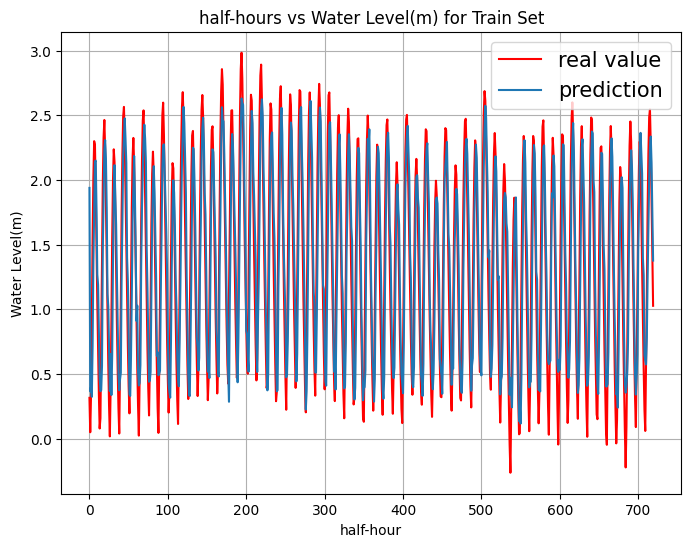

mse: 0.16246226790470475
mae: 0.35605263588281577
rmse: 0.40306608379359427
R²:  0.7359051736495441
Burlington Station.csv
-------------------------
For HONOLULU Station.cs
The length of train data, validation data and test data are: 5132 , 720 , 718
The total number of train windows is 5131
The total number of validation windows is 720
The total number of validation windows is 720


C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_4292\616683049.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_val=np.array([x[1] for x in val_inout_seq]).squeeze(1)


AxisError: axis 1 is out of bounds for array of dimension 1

In [132]:
import os
import glob

csv_path = '../Data/NOAA/All Station'
csv_files = glob.glob(os.path.join(csv_path, '*.csv'))
# moth = [3,6,9,12]
for file in csv_files:
    if  file!= 'Burlington Station.csv':
        LightGBM_All(os.path.basename(file))
        print(os.path.basename(file))
        print("-------------------------")

# 导入数据

这次我们准备使用五个监测站的数据。假定Bloomsbury监测站的数据出现异常，此时我们用Marylebone Road, Eltham, Harlington和N_Kensington的数据来推断Marylebone的数据。注意，该实验将会先从多变量预测开始预测，然后会从单变量开始预测

In [155]:
CN_Cha_Data=pd.read_csv('../Data/PreData/ArtiData/FLX_AU-ASM_FLUXNET2015_FULLSET_HH_2010-2014_2-4.csv')
# CN_Cha_Data = pd.read_csv('../Database/NERL/NERL_2009_2020.csv')
# CN_Cha_Data=pd.read_csv('../Database/FLUXNET2015/MultSiteData/ChinaData/FLX_CN-Cha_FLUXNET2015_HH_2003-2005.csv')
# Bloomsbury=pd.read_csv('data/Bloomsbury_clean.csv')
# Eltham=pd.read_csv('data/Eltham_clean.csv')
# Harlington=pd.read_csv('data/Harlington_clean.csv')
# N_Kensington=pd.read_csv('data/N_Kensington_clean.csv')

In [156]:
CN_Cha_Data.head()

,TIMESTAMP_START,SW_IN_F_F,SW_IN_F,TA_F_F,TA_F,LW_IN_F_F,LW_IN_F,VPD_F_F,VPD_F,PA_F_F,PA_F,WS_F_F,WS_F,RH_F,RH
0,2010/1/1 6:30,1.591293,13.638534,26.890,26.662,397.338,409.53,15.989,15.319,93.836,93.860,1.019,0.943,-9999,-9999
1,2010/1/1 7:00,13.638534,22.658362,26.662,27.575,409.530,409.53,15.319,17.531,93.860,93.874,0.943,0.930,-9999,-9999
2,2010/1/1 7:30,22.658362,31.497500,27.575,28.487,409.530,409.53,17.531,19.743,93.874,93.889,0.930,0.918,-9999,-9999
3,2010/1/1 8:00,31.497500,40.004828,28.487,29.400,409.530,409.53,19.743,21.955,93.889,93.903,0.918,0.905,-9999,-9999
4,2010/1/1 8:30,40.004828,48.034914,29.400,30.312,409.530,409.53,21.955,24.166,93.903,93.918,0.905,0.893,-9999,-9999


In [157]:
CN_Cha_Data =CN_Cha_Data[['SW_IN_F_F','SW_IN_F','TA_F_F','TA_F','LW_IN_F_F','LW_IN_F','VPD_F_F','VPD_F','PA_F_F','PA_F','WS_F_F','WS_F','RH_F','RH']]
# CN_Cha_Data =CN_Cha_Data[['DHI','DNI','Dew Point','Surface Albedo','Wind Speed','Relative Humidity','Temperature','Pressure']]
# Bloomsbury=Bloomsbury[['nox','no2','no','o3','pm2.5','ws','wd','air_temp']]
# Eltham=Eltham[['nox','no2','no','o3','pm2.5','ws','wd','air_temp']]
# Harlington=Harlington[['nox','no2','no','o3','pm2.5','ws','wd','air_temp']]
# N_Kensington=N_Kensington[['nox','no2','no','o3','pm2.5','ws','wd','air_temp']]

先将每个监测站的columns更名。加上后缀为监测站的首字母

接下来将所有监测站的数据拼接起来

In [158]:
col_CN_ha_Data = [['SW_IN_F_F_CHA','SW_IN_F_CHA','TA_F_F_CHA','TA_F_CHA','LW_IN_F_F_CHA','LW_IN_F_CHA','VPD_F_F_CHA','VPD_F_CHA','PA_F_F_CHA','PA_F_CHA','WS_F_F_CHA','WS_F_CHA','RH_F_CHA','RH_CHA']]
# col_CN_ha_Data=['DHI_CHA','DNI_CHA','Dew Point_CHA','Surface Albedo_CHA','Wind Speed_CHA','Relative Humidity_CHA','Temperature_CHA','Pressure_CHA']
# col_Bloomsbury=['nox_B','no2_B','no_B','o3_B','pm2.5_B','ws_B','wd_B','air_temp_B']
# col_Eltham=['nox_E','no2_E','no_E','o3_E','pm2.5_E','ws_E','wd_E','air_temp_E']
# col_Harlington=['nox_H','no2_H','no_H','o3_H','pm2.5_H','ws_H','wd_H','air_temp_H']
# col_N_Kensington=['nox_N','no2_N','no_N','o3_N','pm2.5_N','ws_N','wd_N','air_temp_N']

CN_Cha_Data.columns=col_CN_ha_Data

In [159]:
dataset=CN_Cha_Data
# dataset=dataset.join(Eltham)
# dataset=dataset.join(Harlington)
# dataset=dataset.join(N_Kensington)
dataset.head()

,SW_IN_F_F_CHA,SW_IN_F_CHA,TA_F_F_CHA,TA_F_CHA,LW_IN_F_F_CHA,LW_IN_F_CHA,VPD_F_F_CHA,VPD_F_CHA,PA_F_F_CHA,PA_F_CHA,WS_F_F_CHA,WS_F_CHA,RH_F_CHA,RH_CHA
0,1.591293,13.638534,26.890,26.662,397.338,409.53,15.989,15.319,93.836,93.860,1.019,0.943,-9999,-9999
1,13.638534,22.658362,26.662,27.575,409.530,409.53,15.319,17.531,93.860,93.874,0.943,0.930,-9999,-9999
2,22.658362,31.497500,27.575,28.487,409.530,409.53,17.531,19.743,93.874,93.889,0.930,0.918,-9999,-9999
3,31.497500,40.004828,28.487,29.400,409.530,409.53,19.743,21.955,93.889,93.903,0.918,0.905,-9999,-9999
4,40.004828,48.034914,29.400,30.312,409.530,409.53,21.955,24.166,93.903,93.918,0.905,0.893,-9999,-9999


# 多站点多变量进行预测

In [160]:
var=dataset.values

划分训练集，验证集和测试集

In [161]:
def splitData(var,per_val,per_test):
    num_val=int(len(var)*per_val)
    num_test=int(len(var)*per_test)
    train_size=int(len(var)-num_val-num_test)
    train_data=var[0:train_size]
    val_data=var[train_size:train_size+num_val]
    test_data=var[train_size+num_val:train_size+num_val+num_test]
    return train_data,val_data,test_data

我们的验证集合测试集都取10%的时间

In [162]:
train_data,val_data,test_data=splitData(var,0.1,0.1)

查看长度

In [163]:
print('The length of train data, validation data and test data are:',len(train_data),',',len(val_data),',',len(test_data))

The length of train data, validation data and test data are: 33233 , 4154 , 4154



取一定大小的窗口进行滑动，每个窗口的label值是窗口下一个预测的第一个空气污染物的值

In [164]:
# train_window = 240
train_window = 1
def create_train_sequence(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [165]:
train_inout_seq = create_train_sequence(train_data, train_window)
print('The total number of train windows is',len(train_inout_seq))

The total number of train windows is 33232


与上面创建train_data的sequence不同，验证集数据(实验是1752个验证集数据)只是label。其数据部分还是需要借助于train集中的数据，大小为一个窗口。而这一个窗口的数据并不会在训练过程中被使用

In [166]:
def create_val_sequence(train_data,val_data, tw):
    temp=np.vstack((train_data,val_data))   #先将训练集和测试集合并
    inout_seq = []
    L = len(val_data)
    for i in range(L):
        val_seq = temp[-(train_window+L)+i:-L+i]
        val_label = test_data[i:i+1]
        inout_seq.append((val_seq ,val_label))

    return inout_seq

In [167]:
val_inout_seq = create_val_sequence(train_data, val_data,train_window)
print('The total number of validation windows is',len(val_inout_seq))

The total number of validation windows is 4154


 此时的label的shape是[1,40]。注意，真正的label只有这40个值中的前五个

In [168]:
def create_test_sequence(train_data,val_data,test_data, tw):
    temp=np.vstack((train_data,val_data))   #先将训练集和测试集合并
    temp=np.vstack((temp,test_data))
    inout_seq = []
    L = len(test_data)
    for i in range(L):
        test_seq = temp[-(train_window+L)+i:-L+i]
        test_label = test_data[i:i+1]
        inout_seq.append((test_seq,test_label))
        # print('test_reshape:',test_seq.reshape(-1))
        # inout_seq.append((test_seq.reshape(-1) ,test_label))

    return inout_seq

In [169]:
test_inout_seq = create_test_sequence(train_data, val_data, test_data,train_window)
print('The total number of validation windows is',len(val_inout_seq))

The total number of validation windows is 4154


In [170]:
X_train=np.array([x[0] for x in train_inout_seq])
y_train=np.array([x[1] for x in train_inout_seq]).squeeze(1)

X_val=np.array([x[0] for x in val_inout_seq])
y_val=np.array([x[1] for x in val_inout_seq]).squeeze(1)

X_test=np.array([x[0] for x in test_inout_seq])
y_test=np.array([x[1] for x in test_inout_seq]).squeeze(1)


In [171]:
X_train.shape

(33232, 1, 14)

In [172]:
y_test

array([[57.06896552, 50.43103448, 19.36      , ...,  2.08      ,
        18.        , 17.        ],
       [50.43103448, 42.67241379, 19.96      , ...,  2.34      ,
        17.        , 15.        ],
       [42.67241379, 33.70689655, 20.46      , ...,  2.        ,
        15.        , 14.        ],
       ...,
       [43.53448276, 33.10344828, 35.22      , ...,  2.19      ,
        11.        , 11.        ],
       [33.10344828, 20.17241379, 35.41      , ...,  2.36      ,
        11.        , 11.        ],
       [20.17241379,  9.56896552, 35.18      , ...,  2.04      ,
        11.        , 12.        ]])

In [173]:
X_train = X_train.reshape(len(X_train),-1)
y_train = y_train.reshape(len(y_train),-1)

X_val = X_val.reshape(len(X_val),-1)
y_val = y_val.reshape(len(X_val),-1)

X_test = X_test.reshape(len(X_test),-1)
y_test = y_test.reshape(len(y_test),-1)

In [174]:
print(X_train.shape)
print(X_val.shape)

(33232, 14)
(4154, 14)


下面是lightgbm的参数

In [175]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 29,
    'learning_rate': 0.09,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 6,
    'verbose': 0
}

In [176]:
# # 修改后的超参-SW_IN_F R²=0.9+
# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': {'l2', 'l1'},
#     'num_leaves': 100,
#     'learning_rate': 0.01,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 6,
#     'verbose': 0
# }

下面的字典用于存放不同污染物的index

In [177]:
index_dic={
    'SW_IN_F_F':0,
    'SW_IN_F':1,
    # 'ss':2
}

In [178]:
# index_dic = {
#     'DHI':0,
#     'DNI':1,
#     'Dew Point':2,
#     'Surface Albedo':3,
#     'Wind Speed':4,
#     'Relative Humidity':5,
#     'Temperature':6,
#     'Pressure':7
#
# }

In [179]:
X_test.shape

(4154, 14)

In [180]:
X_test

array([[62.32758621, 57.06896552, 18.92      , ...,  2.24      ,
        19.        , 18.        ],
       [57.06896552, 50.43103448, 19.36      , ...,  2.08      ,
        18.        , 17.        ],
       [50.43103448, 42.67241379, 19.96      , ...,  2.34      ,
        17.        , 15.        ],
       ...,
       [53.18965517, 43.53448276, 35.48      , ...,  2.41      ,
        11.        , 11.        ],
       [43.53448276, 33.10344828, 35.22      , ...,  2.19      ,
        11.        , 11.        ],
       [33.10344828, 20.17241379, 35.41      , ...,  2.36      ,
        11.        , 11.        ]])

In [181]:
import copy
X_test_mask=copy.copy(X_test)

In [182]:
a = X_test_mask[1]

In [183]:
a

array([ 57.06896552,  50.43103448,  19.36      ,  19.96      ,
       277.        , 279.        ,  18.433     ,  19.365     ,
        94.97      ,  94.95      ,   2.24      ,   2.08      ,
        18.        ,  17.        ])

In [184]:
# a[0][1]

In [185]:
# X_test_mask[i+1,1*index_dic[attr]]=y_pred

In [186]:
import copy
from sklearn.preprocessing import  MinMaxScaler as MinMax
from sklearn.metrics import r2_score
def predict_lgb_mul(attr):
  lgb_train = lgb.Dataset(X_train,y_train[:,index_dic[attr]])
  lgb_val = lgb.Dataset(X_val, y_val[:,index_dic[attr]], reference=lgb_train)

  gbm = lgb.train(params,
                  lgb_train,
                  num_boost_round=100,
                  valid_sets=lgb_val,
                  # early_stopping_rounds=5
                  )

  y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

  x = np.arange(len(train_data)+len(val_data), len(dataset), 1)
  plt.figure(figsize=(8, 6))
  plt.grid(True)

  plt.plot(dataset.loc[len(dataset)-len(test_data):,attr+'_CHA'][0:300].values,color="red",label='real value')
  plt.plot(y_pred[0:300],label='prediction')

  plt.title('half-hours vs '+attr+' for Train Set')
  plt.ylabel(attr)
  plt.xlabel('half-hour')

  plt.legend(loc='upper right',fontsize=15)
  # plt.savefig('lightGBM_SW_IN_F_Train.png')
  plt.show()
  scaler = MinMax(feature_range=(0,1))
  y_trian_true_scaled = scaler.fit_transform(np.array(y_test[:,index_dic[attr]]).reshape(-1,1))
  y_trian_pred_scaled = scaler.fit_transform(np.array(y_pred).reshape(-1,1))

  # print("============归一化前的结果==============")
  print('mse:', mean_squared_error(y_test[0:300,index_dic[attr]], y_pred[0:300]))
  print('mae:', mean_absolute_error(y_test[0:300,index_dic[attr]], y_pred[0:300]))
  print('rmse:', np.sqrt(mean_squared_error(y_test[0:300,index_dic[attr]], y_pred[0:300])))
  print('R²: ',r2_score(y_test[0:300,index_dic[attr]], y_pred[0:300]))

  y_true = y_test[0:300,index_dic[attr]]
  # y_pred = y_pred[0:300]
  # y_pred=pd.DataFrame(y_pred)
  # y_true=pd.DataFrame(y_true)
  print('y_true:',y_true)
  # y_pred.to_csv('PredictionResult/SW_TA_LW_VPD_PA_WS_RH/'+'LightGBM'+'_YPre_'+''+attr+'.csv',index=False)
  # y_true.to_csv('PredictionResult/SW_TA_LW_VPD_PA_WS_RH/'+'LightGBM'+'_YTrue_'+attr+'.csv',index=False)









  # y_pred=pd.DataFrame(y_pred)
  # y_pred.to_csv("/content/drive/My Drive/air_inference/result/lgb_mul_"+attr+".csv",header = None, index = None)
  # print("============归一化后的结果==============")
  # print('mse: ',mean_squared_error(y_trian_true_scaled, y_trian_pred_scaled))
  # print('rmse: ',np.sqrt(mean_squared_error(y_trian_true_scaled, y_trian_pred_scaled)))
  # print('mae: ',mean_absolute_error(y_trian_true_scaled, y_trian_pred_scaled))
  # print('R²: ',r2_score(y_trian_true_scaled, y_trian_pred_scaled))

  #预测24小时之后的情况
  # fut_pred = 480
  # pred_list=[]
  # X_test_mask=copy.copy(X_test)
  #
  # for i in range(fut_pred):
  #   y_pred = gbm.predict(X_test_mask[i].reshape(1,-1), num_iteration=gbm.best_iteration)
  #   pred_list.append(y_pred)
  #
  #   if(i!=fut_pred-1):
  #     X_test_mask[i+1,1*index_dic[attr]]=y_pred
  #
  #
  # plt.figure(figsize=(8, 6))
  # plt.grid(True)
  #
  # plt.plot(dataset.loc[len(dataset)-len(test_data):len(dataset)-len(test_data)+fut_pred,attr+'_CHA'].values,color="red",label='real value')
  # plt.plot(pred_list,label='prediction')
  #
  # plt.title('half-hours vs '+attr+' for Test Set')
  # plt.ylabel(attr)
  # plt.xlabel('half-hour')
  #
  # plt.legend(loc='upper right',fontsize=15)
  # plt.savefig('lightGBM_SW_IN_F_Test.png')
  # plt.show()
  # y_true=dataset.loc[len(dataset)-len(test_data):len(dataset)-len(test_data)+fut_pred-1,attr+'_CHA'].values
  # y_pred=pred_list
  #
  # # print(y_true)
  # # print(y_pred)
  #
  # scaler = MinMax(feature_range=(0,1))
  # y_true_scaled = scaler.fit_transform(np.array(y_true).reshape(-1,1))
  # y_pred_scaled = scaler.fit_transform(np.array(y_pred).reshape(-1,1))
  #
  # # print(y_true_scaled)
  # # print(y_pred_scaled)
  #
  # # print("============归一化前的结果==============")
  # print('mse: ',mean_squared_error(y_true, y_pred))
  # print('rmse: ',np.sqrt(mean_squared_error(y_true, y_pred)))
  # print('mae: ',mean_absolute_error(y_true, y_pred))
  # print('R²: ',r2_score(y_true, y_pred))
  # #
  # # print("============归一化后的结果==============")
  # # print('mse: ',mean_squared_error(y_true_scaled, y_pred_scaled))
  # # print('rmse: ',np.sqrt(mean_squared_error(y_true_scaled, y_pred_scaled)))
  # # print('mae: ',mean_absolute_error(y_true_scaled, y_pred_scaled))
  # # print('R²: ',r2_score(y_true_scaled, y_pred_scaled))
  #
  #
  #
  # y_pred=pd.DataFrame(y_pred)
  # y_true=pd.DataFrame(y_true)
  #
  # # y_pred.to_csv('result24/lightGBM_'+attr+'.csv',index=False)
  # # y_true.to_csv('result24/true_'+attr+'.csv',index=False)
  #
  #
  #
  #
  #
  #
  #
  #
  #
  # # y_pred=pd.DataFrame(y_pred)
  # # y_pred.to_csv("/content/drive/My Drive/air_inference/result/lgb_mul_"+attr+".csv",header = None, index = None)

对nox进行预测

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's l2: 816.263	valid_0's l1: 24.9335
[2]	valid_0's l2: 832.899	valid_0's l1: 25.0757
[3]	valid_0's l2: 856.061	valid_0's l1: 25.2824
[4]	valid_0's l2: 882.965	valid_0's l1: 25.5326
[5]	valid_0's l2: 912.909	valid_0's l1: 25.8279
[6]	valid_0's l2: 944.428	valid_0's l1: 26.1362
[7]	valid_0's l2: 976.709	valid_0's l1: 26.4534
[8]	valid_0's l2: 1009.31	valid_0's l1: 26.7729
[9]	valid_0's l2: 1034.81	valid_0's l1: 27.0282
[10]	valid_0's l2: 1066.22	valid_0's l1: 27.3377
[11]	valid_0's l2: 1096.47	valid_0's l1: 27.6358
[12]	valid_0's l2: 1125.36	valid_0's l1: 27.9213
[13]	valid_0's l2: 1153.44	valid_0's l1: 28.2012
[14]	valid_0's l2: 1179.7	valid_0's l1: 28.4658
[15]	valid_0's l2: 1204.49	valid_0's l1: 28.7179
[16]	valid_0's l2: 1227.74	valid_0's l1: 28.9527
[17]	valid_0's l2: 1249.56	valid_0's l1: 29.1786
[18]	valid_0

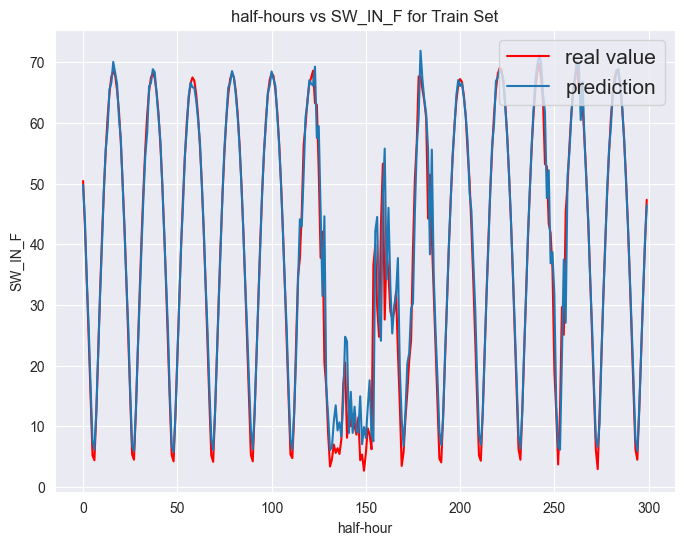

mse: 22.268994319558608
mae: 2.4877989609347817
rmse: 4.719003530360897
R²:  0.9540691953529965
y_true: [50.43103448 42.67241379 33.70689655 24.05172414 14.13793103  5.17241379
  4.39655172 12.15517241 21.98275862 31.98275862 40.94827586 48.62068966
 55.43103448 60.94827586 64.9137931  67.67241379 68.44827586 67.84482759
 65.43103448 62.06896552 56.81034483 49.9137931  42.5        33.62068966
 24.13793103 14.22413793  5.34482759  4.48275862 12.5862069  22.32758621
 31.98275862 41.03448276 48.96551724 55.77586207 61.37931034 65.17241379
 67.5        68.27586207 67.4137931  65.         61.55172414 56.37931034
 50.         42.24137931 33.36206897 23.79310345 14.05172414  5.25862069
  4.22413793 12.15517241 21.46551724 30.94827586 39.82758621 47.67241379
 54.48275862 60.0862069  63.96551724 66.46551724 67.5        66.98275862
 64.74137931 61.12068966 56.03448276 49.82758621 41.98275862 33.18965517
 23.44827586 13.87931034  5.17241379  4.13793103 12.24137931 21.89655172
 31.46551724 40.4310

In [187]:
%%time
predict_lgb_mul('SW_IN_F')

对no2进行预测

对no进行预测

In [441]:
# %%time
# predict_lgb_mul('LW_IN_F')

In [442]:
# %%time
# predict_lgb_mul('LW_IN_F')

对o3进行预测

对pm2.5进行预测

# 对单站点多变量进行预测

In [443]:
#数据集
dataset=CN_Cha_Data.values

#划分数据集
train_data,val_data,test_data=splitData(dataset,0.1,0.1)

train_window=240
train_inout_seq = create_train_sequence(train_data, train_window)
val_inout_seq = create_val_sequence(train_data, val_data,train_window)
test_inout_seq = create_test_sequence(train_data, val_data, test_data,train_window)

def predict_lgb_sin(attr):

  X_train=np.array([x[0] for x in train_inout_seq])
  y_train=np.array([x[1] for x in train_inout_seq]).squeeze(1)

  X_val=np.array([x[0] for x in val_inout_seq])
  y_val=np.array([x[1] for x in val_inout_seq]).squeeze(1)

  X_test=np.array([x[0] for x in test_inout_seq])
  y_test=np.array([x[1] for x in test_inout_seq]).squeeze(1)

  lgb_train = lgb.Dataset(X_train,y_train[:,index_dic[attr]])
  lgb_val = lgb.Dataset(X_val, y_val[:,index_dic[attr]], reference=lgb_train)

  gbm = lgb.train(params,
                  lgb_train,
                  num_boost_round=30,
                  valid_sets=lgb_val,
                  # early_stopping_rounds=5
                  )

  y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

  print(y_pred.shape)

  print('mse:', mean_squared_error(y_test[:,index_dic[attr]], y_pred))
  print('mse:', mean_absolute_error(y_test[:,index_dic[attr]], y_pred))

  y_pred=pd.DataFrame(y_pred)
  # y_pred.to_csv("/content/drive/My Drive/air_inference/result/lgb_single_"+attr+".csv",header = None, index = None)

对nox进行预测

In [444]:
%%time
predict_lgb_sin('SW_IN_F')

ValueError: Input numpy.ndarray must be 2 dimensional

对no2进行预测

In [445]:
%%time
predict_lgb_sin('no2')

KeyError: 'no2'

对no进行预测

In [446]:
%%time
predict_lgb_sin('no')

KeyError: 'no'

对o3进行预测

In [447]:
%%time
predict_lgb_sin('o3')

KeyError: 'o3'

对pm2.5进行预测

In [448]:
predict_lgb_sin('pm2.5')

KeyError: 'pm2.5'